このノートブックでは、与えられたデータセットに関する基本情報を試してみましょう。このコンペのデータセットは、時間の経過とともに顧客の注文を記述するファイルのリレーショナルセットです。

目的：

競争の目標は、どの製品がユーザーの次の順序になるかを予測することです。このデータセットは匿名化されており、Instacartの200,000人以上のユーザーから300万件を超えるサンプルを提供しています。

各ユーザーに対して、4つの注文と100の注文が与えられ、各注文で購入された一連の製品

必要なモジュールをインポートすることから始めましょう。

In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#.color_paletteメソッドは、RGBタプルのリストを返す
#colorはcolor_paletteのインスタンスメソッド
color = sns.color_palette()

#% matplotlib inline」は
#Jupyter Notebookで、ノートブック上にグラフを描画する際に指定する記述です
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

この大会に出席しているファイルをリストアップしましょう。

In [79]:
# subprocessはPythonからコマンドを実行するモジュール
#外部のコマンドを実行したり、外部ファイルを実行したり、カレントディレクトリを移動できる
#check_outputメソッドは実行時の出力、エラーは実行されたタイミングで出力され,正常にコマンドが実行された場合は、バイト文字列で出力を返す

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
order_products__prior.csv
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv
orders.csv.zip
products.csv
products.csv.zip
sample_submission.csv
sample_submission.csv.zip



私たちが探索的分析に深く入る前に、与えられたファイルについてもう少し詳しくお聞かせください。それをよりよく理解するためには、最初にすべてのファイルをデータフレームオブジェクトとして読み込み、上の数行を見てみましょう。


In [80]:
#csvファイルを読み込んでそれぞれ変数に代入
order_products_train_df = pd.read_csv("input/order_products__train.csv")
order_products_prior_df = pd.read_csv("input/order_products__prior.csv")
orders_df = pd.read_csv("input/orders.csv")
products_df = pd.read_csv("input/products.csv")
aisles_df = pd.read_csv("input/aisles.csv")
departments_df = pd.read_csv("input/departments.csv")

In [81]:
#orders_dfの概要を把握するためにheadで最初のインデックスから５つを確認
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [82]:
#概要を把握するためにheadで最初のインデックスから５つを確認
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [83]:
#概要を把握するためにheadで最初のインデックスから５つを確認
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



今回は過去の購入履歴から次の購入履歴を予測する。
つまり、priorファイルにはtrain,test両方の購入履歴が含まれており、order_products_train_dfは学習用の正解データということ。
https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33448
従って、eval_set=testの'reordered'が今回予測すべきターゲットである。



わかったように、orders.csvには、注文を購入したユーザー、注文した日、前の注文日などのような、指定した注文IDに関するすべての情報が含まれています。

order_products_trainとorder_products_priorにある列は同じです。次に、これらのファイルの違いは何ですか？

前述のように、このデータセットでは、顧客の4から100の注文が与えられます（これについては後で説明します）、再注文される製品を予測する必要があります。ユーザーの最後の注文が取り出され、電車とテストセットに分かれています。 order_products_priorファイルには、顧客のすべての事前注文情報が含まれています。また、eval_setと呼ばれるorders.csvファイルには、与えられた行がどの3つのデータセット（先行、列車またはテスト）のどれに向いているかを示す列があります。

Order_products * csvファイルには、指定された順序で購入された製品に関する詳しい情報と、並べ替えられた状態が含まれています。

最初に、3つのセットのそれぞれの行の数を取得しましょう。

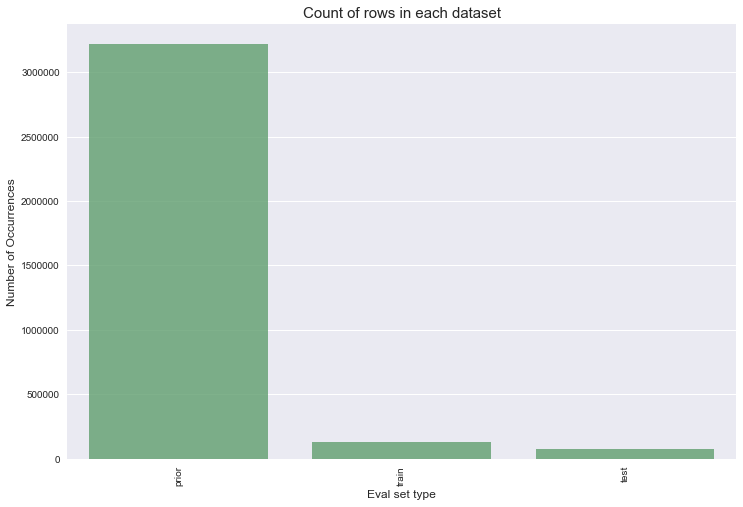

In [84]:
#eval_set列の各単語の出現数をカウントする
cnt_srs = orders_df.eval_set.value_counts()
#フィギュアインスタンスを作成する（サイズを指定）
plt.figure(figsize=(12,8))
#棒グラフを作成する（x軸をカウント時に見つかった単語、y軸をカウント数、不透明度0.８、緑指定）
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
#y軸のラベルを指定する
plt.ylabel('Number of Occurrences', fontsize=12)
#x軸のラベルを指定する
plt.xlabel('Eval set type', fontsize=12)
#グラフのタイトルを設定する
plt.title('Count of rows in each dataset', fontsize=15)
#x軸のメモリの文字を回転して垂直にする
plt.xticks(rotation='vertical')
#表示
plt.show()


これまでの内容からeval_setとreorderedで可視化すれば何か分析できるとわかる
以下では、まず,prior,train,testにそれぞれ何人userがいるか可視化して
orders_dfをeval_setでグループ化し、各グループ内でuser_idを重複無しでcountする

In [85]:
def get_unique_count(x):
    return len(np.unique(x))
#groupbyは引数に列名を指定するとその列の値ごとにグループングされる。返されるのはGroupByオブジェクトで
#それ自体をprintで出力しても中身は表示されない
#aggregateはgroupbyしたグループに様々な関数を適応するメソッド
#eval_set列の値の違いでuser_id列の値をグループ分けして、その結果に対してget_unique_count
#でユニークな要素の数を数えて、それらを一覧にしてcnt_srsに入れる
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

複数のpriorからtrain、testを予測するのでpriorが圧倒的に多いことがわかる


だから合計206,209人の顧客がいる。そのうち、131,209人の顧客の最後の購入が列車として与えられ、残りの75,000人の顧客を予測する必要があります。

今度は、顧客の4から100件の注文が与えられたという主張を検証しましょう。


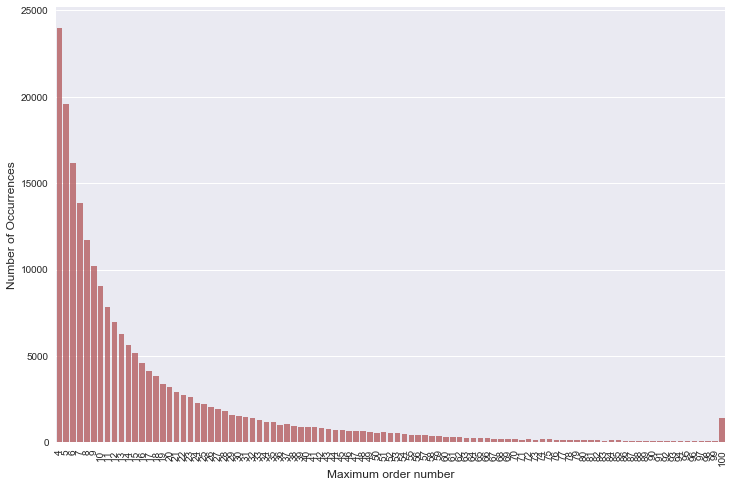

In [86]:
#reset_indexはインデックスをリセットする

cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
#value_counts()は、ユニークな要素の値がindex、その出現個数がdataとなるpandas.Seriesを返す。要素の頻度（出現回数）が必要な場合はこちらを使う。
cnt_srs = cnt_srs.order_number.value_counts()
#figureインスタンスを作成
plt.figure(figsize=(12,8))
#barplotは棒グラフを描画、x軸にcnt_srs.index、y軸にcnt_srs.valuesを指定
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
#y軸のラベルを指定
plt.ylabel('Number of Occurrences', fontsize=12)
#x軸のラベルを指定
plt.xlabel('Maximum order number', fontsize=12)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#表示
plt.show()

したがって、4未満の注文はなく、データページで指定されているように、100で上限が上限になります。

今、注文習慣が曜日によってどのように変化するかを見てみましょう。

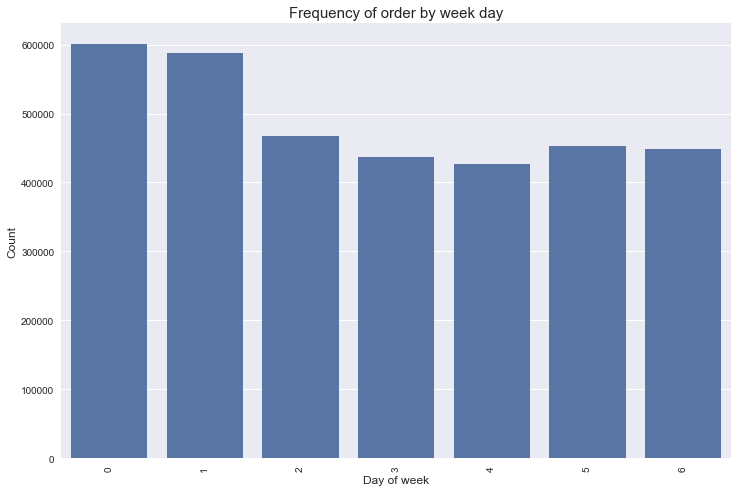

In [87]:
#新規のウィンドウを描画
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
#y軸のラベルを設定
plt.ylabel('Count', fontsize=12)
#x軸のラベルを設定
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
#グラフのタイトルを設定
plt.title("Frequency of order by week day", fontsize=15)
plt.show()


水曜日に受注が高値と安値の土曜日と日曜日は0と1のようです。

今、私たちはその日の時間に関してどのように分布しているかを見るでしょう。

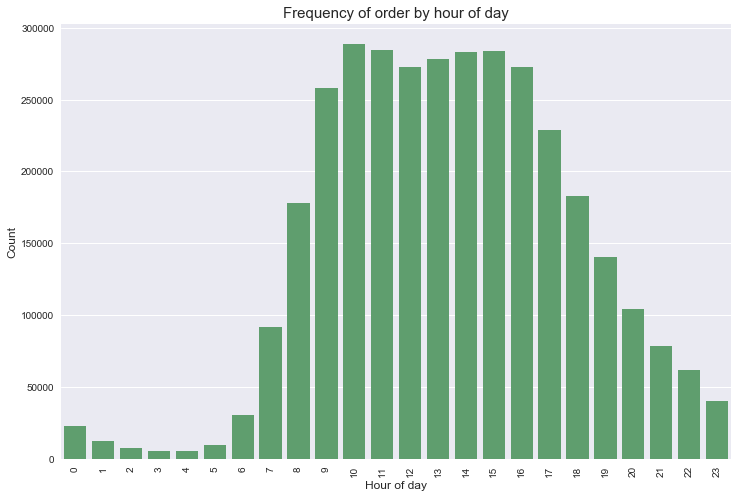

In [88]:
#新規のウィンドウを描画
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
#y軸のラベルを指定
plt.ylabel('Count', fontsize=12)
#x軸のラベルを指定
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
#タイトルを指定
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

したがって、注文の大半は昼間に行われます。さて、曜日と時間を組み合わせて分布を見てみましょう。

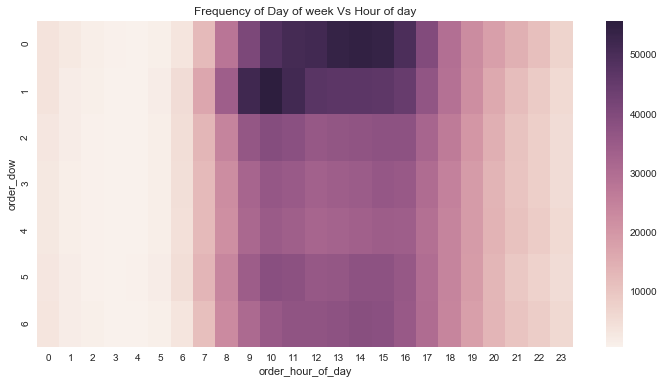

In [89]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
#新規のウィンドウを描画
plt.figure(figsize=(12,6))
#grouped_dfのヒートマップを描画
sns.heatmap(grouped_df)
#タイトルを設定
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Satudayの夜と日曜の朝は注文の最期です。

さて、注文間の時間間隔を確認しましょう。

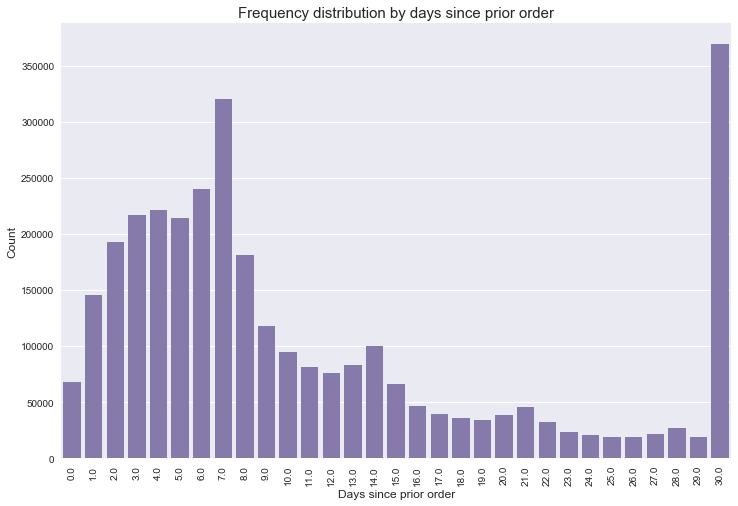

In [90]:
#新規のウィンドウを描画
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
#y軸のラベルを描画
plt.ylabel('Count', fontsize=12)
#x軸のラベルを描画
plt.xlabel('Days since prior order', fontsize=12)

plt.xticks(rotation='vertical')
#タイトルを描画
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

顧客は毎週1回（ピークを7日で確認）または1ヶ月に1回（30日でピーク）のように見えます。また、14日、21日および28日（週ごとの間隔）でより小さいピークを見ることができた。

私たちの目的は再注文を把握することですので、事前セットと列車セットの再注文率をチェックしましょう

In [91]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [92]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

平均して、オーダー内の製品の約59％が再オーダーされた製品です。

**再注文された商品はありません：**

製品の59％が再注文されたことを確認したので、再注文された商品がない場合もあります。今すぐ確認しましょう。

In [95]:
#order_idをまとめて、"reordered"をスライス
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
#ixは行、列をラベルまたは番号で指定する。今回はラベルで指定
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/Users/ranmarusato/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [63]:
#order_id列の値に注目してreordered列の値をグループ分けし、グループごとの合計値を計算し、
#行のインデックスとreordered列の列名を追加する
grouped_df = order_products_train_df.groupby("order_id")["reordered"]\
             .aggregate("sum").reset_index()
#reordered列の値が１より大きい場合は１で上書きする
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
#　reordered列の値を合計して行数で割って再注文率を求める
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/Users/ranmarusato/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


1    0.93444
0    0.06556
Name: reordered, dtype: float64

以前のセットの注文の約12％は再注文品がありませんが、列車セットでは6.5％です。

さあ、各注文で買った商品の数を見てみましょう。

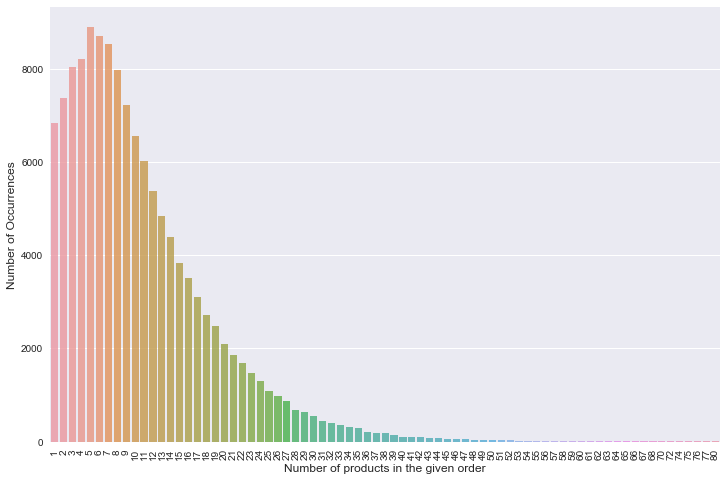

In [64]:

#order_id列の値に注目してadd_to_cart_order列の値をグループ分けし、
#各グループの中の最大値を取得して行のインデックスとadd_to_cart_order列の列名を追加
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()
#新規のウィンドウを描画
plt.figure(figsize=(12,8))
#棒グラフを描画
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
#y軸のラベルを設定
plt.ylabel('Number of Occurrences', fontsize=12)
#x軸のラベルを設定
plt.xlabel('Number of products in the given order', fontsize=12)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#表示
plt.show()

最大値が5の右尾の分布です。

製品の詳細を調べる前に、他の3つのファイルも見てみましょう。

In [65]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [66]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [67]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


商品に関するデータはproducts, aisles, departmentsに分散している。

これらの製品の詳細をorder_priorの詳細とマージしましょう。

In [68]:
#order_products_prior_dfとproducts_dfをproduct_idの値をキーにしてマージする
#howにleftが指定されているので、left側のorder_products_prior_df側のproduct_idの値を
#基準にしてマージする（products_df側にないproduct_id値の行のproducts_dfのデータは
#NaNになる）
order_products_prior_df = pd.merge(order_products_prior_df, products_df,\
                                   on='product_id', how='left')
#order_products_prior_dfとaisles_dfをaisle_idの値をキーにしてマージする
#howにleftが指定されているので、left側のorder_products_prior_df側のaisle_idの値を
#基準にしてマージする（aisles_df側にないaisle_id値の行のaisles_dfのデータは
#NaNになる）
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, \
                                   on='aisle_id', how='left')
#order_products_prior_dfとdepartments_dfをdepartment_idの値をキーにしてマージする
#howにleftが指定されているので、left側のorder_products_prior_df側のdepartment_idの値を
#基準にしてマージする（departments_df側にないdepartment_id値の行のdepartments_dfの
#データはNaNになる）
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, \
                                   on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [69]:
#商品名を分析していく。よく注文されている商品は何か
#value_counts()はユニークな要素の値がindex,その出現個数がdataとなるpd.seriesを返す
#reset_index()でインデックスを０始まりの連番に振り直せる
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
#カウント数の列名がproduct_nameになってしまっているのでリネームする
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


ワオ。それらのほとんどは有機製品です。それらの大部分も果物です。

重要な通路を見てみましょう。

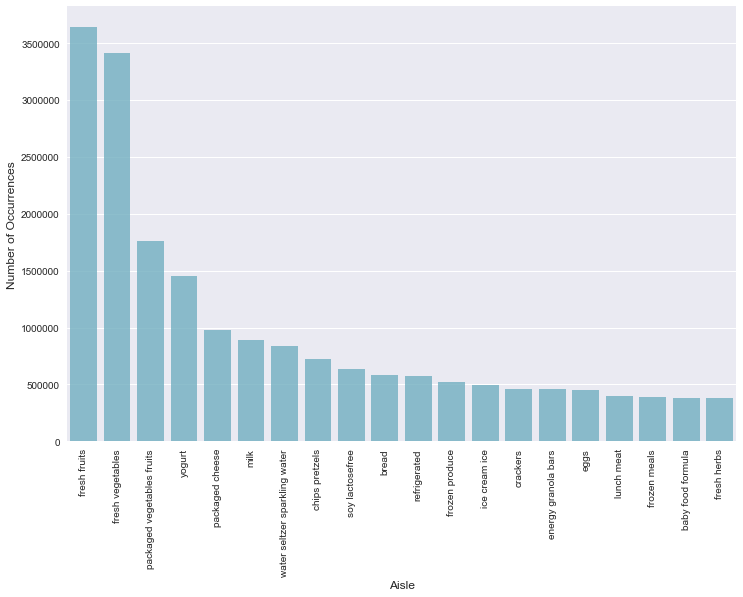

In [70]:
#商品のカテゴリ(aisle)を分析していく
#'aisle'カラムをスライスして、value_counts()はユニークな要素の値がindex,その出現個数がdataとなるpd.seriesを返す
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
#　空の図を描画
plt.figure(figsize=(12,8))
#棒グラフのx軸にcnt_srs のインデックス（商品名）,y軸に出現回数を設定
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
#y軸のラベルを設定
plt.ylabel('Number of Occurrences', fontsize=12)
#x軸のラベルを設定
plt.xlabel('Aisle', fontsize=12)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#表示
plt.show()

上の2つの通路は、新鮮な果物と新鮮な野菜です。

**部局の配布：**

部門別の分布を確認しましょう。

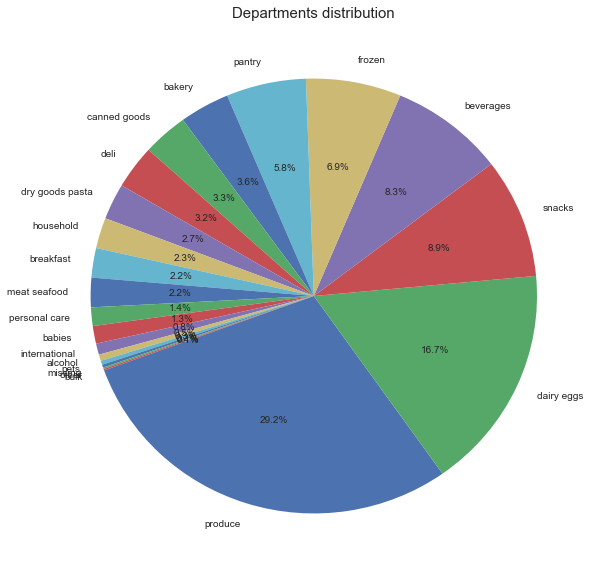

In [71]:
#figureインスタンスを設定
plt.figure(figsize=(10,10))
#'department'カラムをスライスして、value_counts()はユニークな要素の値がindex,その出現個数がdataとなるpd.seriesを返す
temp_series = order_products_prior_df['department'].value_counts()
#temp_seriesのインデックス名をlabekに代入
labels = (np.array(temp_series.index))
#個々の割合を算出し、100をかけることでパーセントの累積が100　となる。
sizes = (np.array((temp_series / temp_series.sum())*100))
#plt.pieは円グラフを描画する
#startangleは各要素の出力を開始する角度
#autopctは構成の割合を小数点以下１桁で出力
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
# タイトルを設定
plt.title("Departments distribution", fontsize=15)
#表示
plt.show()

プロデュースは最大の部門です。さて、各部門の並べ替えられたパーセンテージを確認しましょう。

**部門別再注文率：**

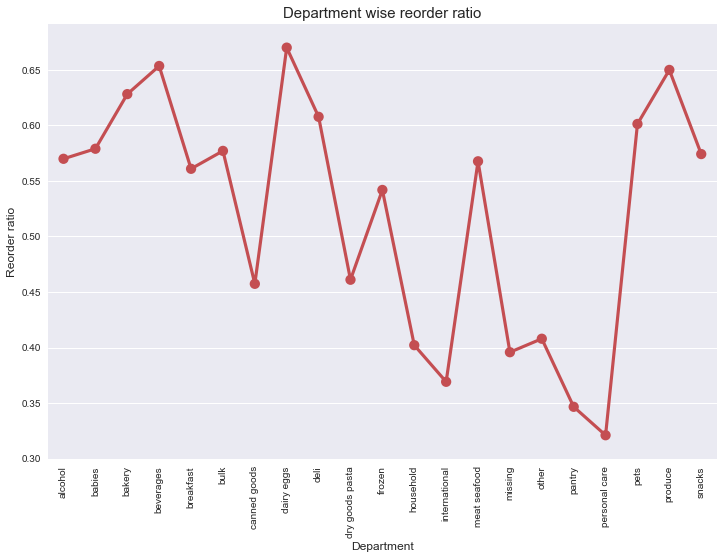

In [72]:
#"department"をgroupbyし"reordered"をスライス。
#平均を出力しreset_index
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
#空の図を描画
plt.figure(figsize=(12,8))
#
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
#y軸のラベルを設定
plt.ylabel('Reorder ratio', fontsize=12)
#x軸のラベルを設定
plt.xlabel('Department', fontsize=12)
#タイトルを設定
plt.title("Department wise reorder ratio", fontsize=15)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#グラフを表示
plt.show()

パーソナルケアは再注文率が最も低く、酪農卵は再注文率が最も高い。

**通路 - 再注文率：**

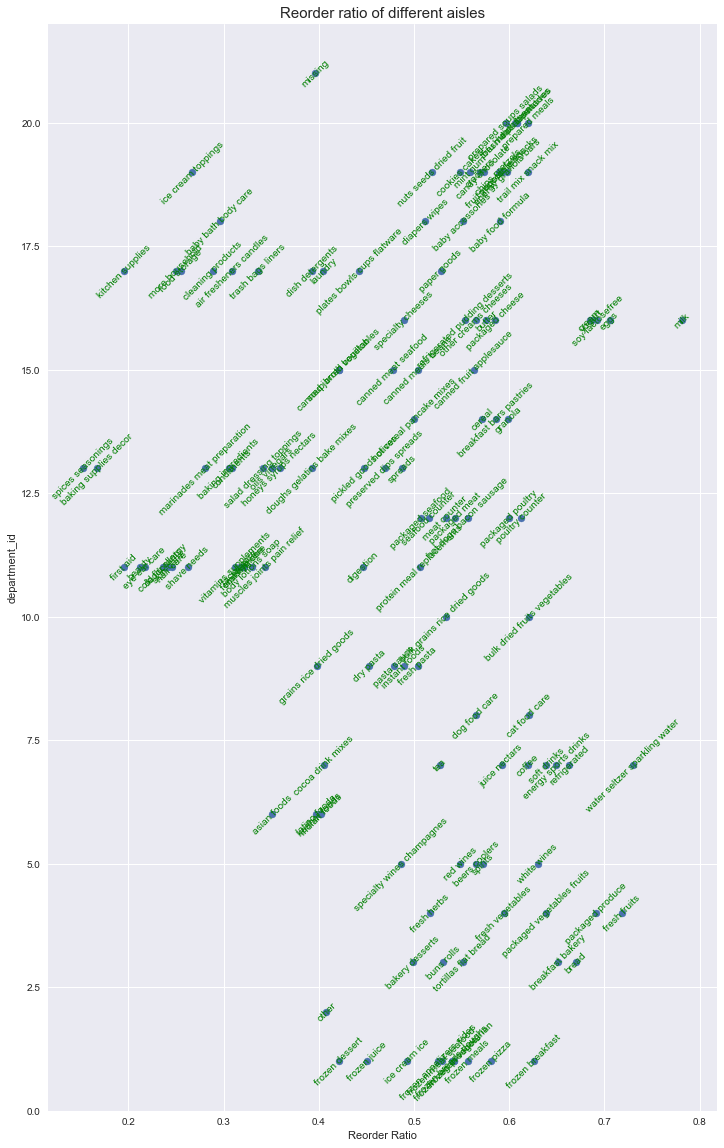

In [73]:
#"department_id", "aisle"をgroupbyし"reordered"をスライス。
#平均を出力しreset_index
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()
#各プロットにアノテーションをつけるためにsubplots関数でAxesオブジェクトを取得する
fig, ax = plt.subplots(figsize=(12,20))
#散布図を作成（x軸は再注文率、y軸は部門ID）
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
#aisle列の各値をtxtに、0から始まる順番をiに入れながら各プロットのアノテーションを作成する
#表示文字は各aisleの値、表示位置は各プロットと同じ位置、表示角度は反時計回りに４５度、
#表示場所での垂直配置は中央、水平配置も中央、緑指定
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
#x軸のラベルを設定
plt.xlabel('Reorder Ratio')
#y軸のラベルを設定
plt.ylabel('department_id')
#　タイトルを設定
plt.title("Reorder ratio of different aisles", fontsize=15)
#表示
plt.show()

**カートに入れる - 注文比率：**

カートに商品を追加する順序が注文比率にどのように影響するかの関係を見てみましょう。

/Users/ranmarusato/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


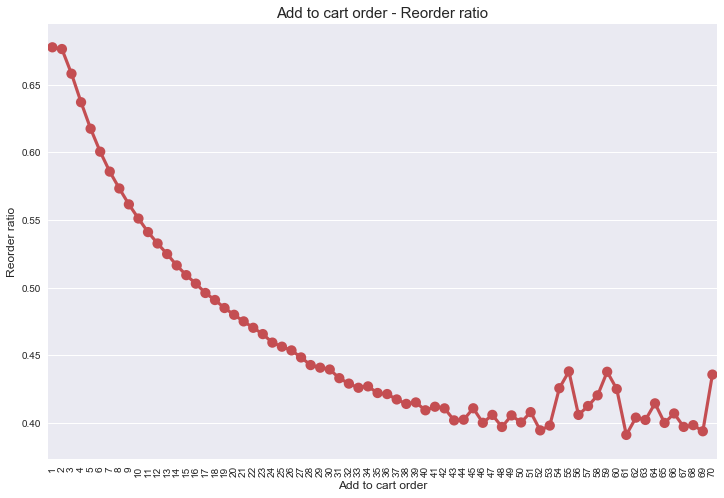

In [74]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()
#空の図を描画
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
#y軸のラベルを描画
plt.ylabel('Reorder ratio', fontsize=12)
#x軸のラベルを描画
plt.xlabel('Add to cart order', fontsize=12)
#タイトルを描画
plt.title("Add to cart order - Reorder ratio", fontsize=15)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#表示
plt.show()

**カートに最初に追加された商品は、後で追加された商品と比べて、再注文される可能性が高いように見えます。**私は頻繁に購入した商品をすべて最初に注文する傾向があるため、利用可能な新製品を見てください。

**時間ベース変数による並べ替え率：**

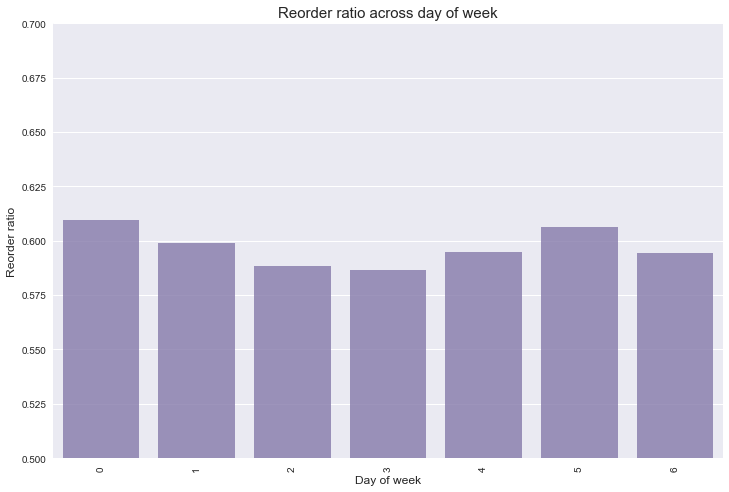

In [75]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
#空の図を描画
plt.figure(figsize=(12,8))
#棒グラフを描画
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
#x軸のタイトルを設定
plt.xlabel('Day of week', fontsize=12)
#タイトルを設定
plt.title("Reorder ratio across day of week", fontsize=15)
#x軸の目盛りの文字を回転させて垂直にする
plt.xticks(rotation='vertical')
#y軸の範囲を0.５〜0.７に限定
plt.ylim(0.5, 0.7)
#表示
plt.show()

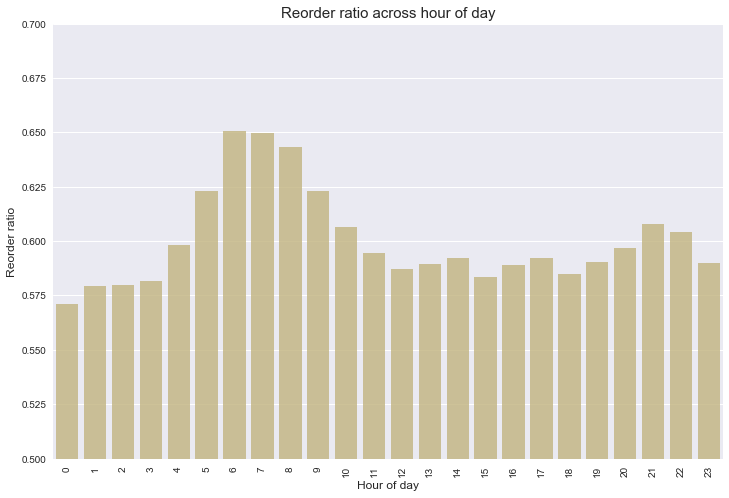

In [76]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
#イfigureンスタンスを作成
plt.figure(figsize=(12,8))
#棒グラフをプロット、横軸に'order_hour_of_dayをスライスしてデータ
#縦軸に'reordered'をスライスしてデータを設定
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
#y軸のラベルを設定
plt.ylabel('Reorder ratio', fontsize=12)
#x軸のラベルを設定
plt.xlabel('Hour of day', fontsize=12)
#タイトルを設定
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

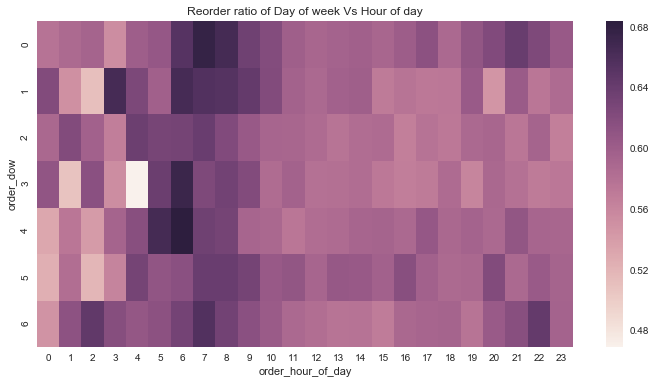

In [77]:

grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
#figureインスタンスを作成
plt.figure(figsize=(12,6))
#grouped_dfのヒートマップを描画
sns.heatmap(grouped_df)
#タイトルを設定
plt.title("Reorder ratio of Day of week Vs Hour of day")
#表示
plt.show()

早朝の再注文率は、後半の半分に比べてかなり高いようです。

**それが助けてくれることを願っている。あなたのコメント/提案を残してください。**